# Quora Insincere Questions Classification
## Detect toxic content to improve online conversations

### Note: Set the colab runtime to None (cpu) for this notebook to work



In [4]:
!wget https://github.com/ravi-ilango/acm-dec-2020-nlp/blob/main/lab2_1/quora_data.zip?raw=true -O quora_data.zip

!unzip quora_data.zip

--2021-03-12 09:59:51--  https://github.com/ravi-ilango/acm-dec-2020-nlp/blob/main/lab2_1/quora_data.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ravi-ilango/aicamp-mar-2021/blob/main/lab2_1/quora_data.zip?raw=true [following]
--2021-03-12 09:59:51--  https://github.com/ravi-ilango/aicamp-mar-2021/blob/main/lab2_1/quora_data.zip?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ravi-ilango/aicamp-mar-2021/raw/main/lab2_1/quora_data.zip [following]
--2021-03-12 09:59:51--  https://github.com/ravi-ilango/aicamp-mar-2021/raw/main/lab2_1/quora_data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ravi-ilango/aicamp-mar-2021/main/lab2_1/

In [15]:
!pip install torch==1.6.0
!pip install torchtext==0.7.0

     |████████████████████████████████| 748.8MB 19kB/s 
ERROR: torchvision 0.9.0+cu101 has requirement torch==1.8.0, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101


     |████████████████████████████████| 4.5MB 4.4MB/s 
     |████████████████████████████████| 1.2MB 36.8MB/s 
  Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0


In [2]:
import random

import os

from datetime import datetime

#deal with tensors
import torch   

#handling text data
from torchtext import data 

import pandas as pd

#for attention LSTM
from torch.autograd import Variable


In [3]:
#Reproducing same results
SEED = 2315

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

### Load custom dataset using torchtext.data.TabularDataset

In [4]:
#loading custom dataset

def tokenizer(text): # create a tokenizer function
    return text.split(' ')

TEXT = data.Field(tokenize=tokenizer,batch_first=True,include_lengths=True)

LABEL = data.LabelField(dtype = torch.float, batch_first=True)

training_data=data.TabularDataset(path = 'quora_data/train.csv',
                                  format = 'csv',
                                  fields = [
                                      (None, None),
                                      ('text', TEXT),
                                      ('label', LABEL)
                                  ],
                                  skip_header = True)

#print preprocessed text
print(vars(training_data.examples[0]))


/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Ple

{'text': ['How', 'did', 'Quebec', 'nationalists', 'see', 'their', 'province', 'as', 'a', 'nation', 'in', 'the', '1960s?'], 'label': '0'}


### Split into training and validation datasets

In [5]:
train_data, test_data = training_data.split(split_ratio=0.5, random_state = random.seed(SEED))
train_data, valid_data = train_data.split(split_ratio=0.4, random_state = random.seed(SEED))


### Prepare input sequence
This step takes 3-5 min

In [6]:
#Build vocab dictionary
TEXT.build_vocab(train_data, min_freq=3, vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

In [7]:
print("Size of TEXT vocabulary: {}\n".format(len(TEXT.vocab)))

print("Size of LABEL vocabulary: {}\n".format(len(LABEL.vocab)))

print("Commonly used words: {}\n".format(TEXT.vocab.freqs.most_common(10)))

#Word dictionary
#TEXT.vocab.stoi

Size of TEXT vocabulary: 47144

Size of LABEL vocabulary: 2

Commonly used words: [('the', 130888), ('What', 83465), ('to', 80575), ('a', 80372), ('in', 72566), ('of', 66277), ('is', 66124), ('I', 61145), ('How', 52158), ('and', 50283)]



### Prepare training data generators

In [35]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 64

#Load an iterator
train_iterator, test_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, test_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


### LSTM Classifier

In [9]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs


#### Instantiate a LSTM Classifier model

In [10]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)



In [11]:
#architecture
print(model)

#No. of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')


classifier(
  (embedding): Embedding(47144, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 4,773,857 trainable parameters
torch.Size([47144, 100])


In [12]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [13]:
device

device(type='cpu')

### Model Train function 

In [14]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Model Evaluate function

In [15]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Check model's forward pass

In [16]:
#Check model device type
next(model.parameters()).is_cuda, device

(False, device(type='cpu'))

In [17]:
for batch in train_iterator:
    #retrieve text and no. of words
    text, text_lengths = batch.text
    print ("text.shape: ", text.shape)
    #convert to 1D tensor
    predictions = model(text, text_lengths)
    print ("predictions.shape: ", predictions.shape)
    break


text.shape:  torch.Size([64, 7])
predictions.shape:  torch.Size([64, 1])


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [26]:
text[0:4]


tensor([[   19,  3219,     0,    74,    27,  1217, 14721],
        [   16,    12, 30593,  6710,    54,    14,   222],
        [    3,    12,    35,    54,   629,  5609,  6331],
        [   19,  4848,   757,   182,    14,    28,  2089]])

In [19]:
model_path = 'saved_weights.pt'

### Train the model

This step takes around ~4 min

In [20]:
N_EPOCHS = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
    
    ts_string = datetime.now().strftime("%m/%d/%Y %H:%M:%S")

    print(f'\n {ts_string} Epoch: {epoch}')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)



 03/12/2021 10:24:13 Epoch: 0
	 Train Loss: 0.151 | Train Acc: 94.60%
	 Val. Loss: 0.129 |  Val. Acc: 95.07%


### Predict

In [29]:
model.embedding

Embedding(47144, 100)

In [21]:
#load weights
model.load_state_dict(torch.load(model_path));
model.eval();

def prepare_text(sentence):
    # Tokenize
    tokenized = [tok for tok in tokenizer(sentence)]
    # Replace tokens by index from dictionary
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    # Convert to tensors
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1).T 
    length = torch.LongTensor(length)
    return tensor, length

def predict(model, sentence):
    tensor, length = prepare_text(sentence)
    prediction = model(tensor, length)                  #prediction 
    return prediction.item()  

In [22]:
sentence = "What is your favorite person in history?"
tokenized = [tok for tok in tokenizer(sentence)]
indexed = [TEXT.vocab.stoi[t] for t in tokenized]
[len(indexed)]

[7]

In [23]:
def insincere_or_not(pred):
    return 'Insincere Question' if pred > .5 else 'Normal Question'

In [24]:
#sincere question
pred = predict(model, "What is your favorite person in history?")
print (insincere_or_not(pred))

Normal Question


In [25]:
#insincere question
pred = predict(model, "Why Indian girls go crazy about marrying Shri. Rahul Gandhiji?")
print (insincere_or_not(pred))

Insincere Question


### Exercise 1

Train the model using the pretrained weights from Glove.  Check the accuracy after 1 epoch and compare.

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)


In [31]:
# TODO 
# Set model embedding's weights to the weights in pretrained_embeddings



In [34]:
# TODO 
# Train the model for 1 epoch and compare loss and accuracy



In [34]:
N_EPOCHS = 1
best_valid_loss = float('inf')

model.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)

model.train()

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
    
    ts_string = datetime.now().strftime("%m/%d/%Y %H:%M:%S")

    print(f'\n {ts_string} Epoch: {epoch}')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)



 03/12/2021 10:50:35 Epoch: 0
	 Train Loss: 0.160 | Train Acc: 94.29%
	 Val. Loss: 0.148 |  Val. Acc: 94.61%


### Exercise 2

Find the threshold to predict insincere comments with high precision (>99%).

In [43]:
def predict (model, iterator):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    preds = []
    labels = []

    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text

            labels_ = batch.label
            
            #convert to 1d tensor
            preds_ = model(text, text_lengths).squeeze()

            preds += preds_.tolist()
            labels += labels_.tolist()
        
    return preds, labels

In [75]:
predprobs, labels = predict(model, test_iterator)

preds = [0 if p < .5 else 1 for p in predprob]

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [76]:
d = {'predprob':predprobs, 'pred':preds, 'label':labels}

df  = pd.DataFrame(d)

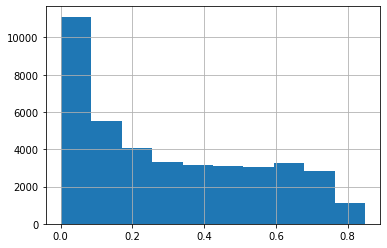

In [77]:
df[df['label']==1]['predprob'].hist()

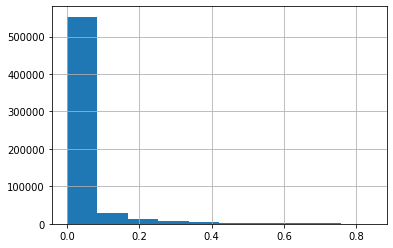

In [78]:
df[df['label']==0]['predprob'].hist()

In [95]:
def precision (df):
  p = len(df[df['pred'] == 1])
  tp = len(df[(df['pred'] == 1) & (df['label'] == 1)])
  return tp / p

In [96]:
precision(df)

0.6596868398160806

##TODO

Find the optimal threshold to use to achieve >99% precision.

- Write a function to calculate precision based on predprobs, labels, threshold
- Search for optimal threshold to achieve >99% precision

### Exercise 3

Discuss thresholding practices used in implementing solutions in a business environment.

### Note

This notebook used data and code from a blog in https://www.analyticsvidhya.com